In [262]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('dataset.csv')
data.head()

,sentiment,comment
0,negative,"﻿nói thật APPLE xài chán , đang xài ip_6_plus ..."
1,negative,Ah con bác bắt wifi thế_nào . Sao mình thấy hơ...
2,negative,kiếm cái logo táo dán lên_mặt sau nữa_là y_cha...
3,positive,rất đáng mua đặc_biệt hàng Nhật luôn có_tiếng ...
4,positive,"Đặt AW vô những nước phát_triển như Mỹ , Úc , ..."


<AxesSubplot:xlabel='sentiment', ylabel='count'>

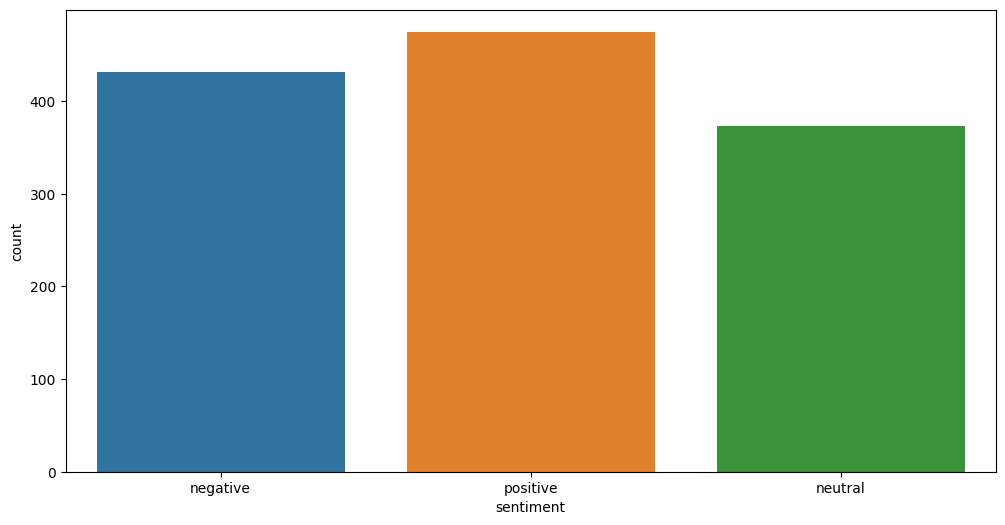

In [263]:
plt.figure(figsize=(12,6))
sns.countplot(x='sentiment',data=data)

In [264]:
temp = data.groupby('sentiment').count()['comment'].reset_index().sort_values(by='comment',ascending=False)
temp.style.background_gradient(cmap='Purples')

,sentiment,comment
2,positive,475
0,negative,431
1,neutral,373


In [265]:
words = data['comment'].apply(lambda x:str(x).split())
top = Counter([item for sublist in words for item in sublist])
temp = pd.DataFrame(top.most_common(15))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,.,1922
1,",",1762
2,là,592
3,có,553
4,thì,529
5,không,422
6,và,373
7,của,364
8,dùng,364
9,mình,361


Preprocessing

In [266]:
import numpy as np 
import pandas as pd 
import urllib.request as requests
import re
from collections import Counter
import string


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import plotly.express as px

In [267]:

# Preprocessing
def preprocess(input:str):
    data = requests.urlopen(r"https://raw.githubusercontent.com/stopwords/vietnamese-stopwords/master/vietnamese-stopwords-dash.txt")
    stop_words = [item.decode("utf-8").strip() for item in list(data)]
    # Lower
    input = input.lower()
    # clean
    input = input.strip().replace('\n', '')
    # Only words
    input = re.sub('\[.*?\]', '', input)
    input = re.sub('https?://\S+|www\.\S+', '', input)
    input = re.sub('<.*?>+', '', input)
    input = re.sub('[%s]' % re.escape(string.punctuation), '', input)
    input = re.sub('\n', '', input)
    input = re.sub('\w*\d\w*', '', input)
    
    return ' '.join([item for item in input.split() if item not in stop_words])
data.dropna()
data["comment"] = data["comment"].apply(lambda x: preprocess(x))
data.head()

,sentiment,comment
0,negative,﻿nói apple xài chán xài lúcnào cậpnhật vá lỗi ...
1,negative,ah bắt wifi thếnào hơi kém
2,negative,kiếm logo táo dán lênmặt nữalà ychang
3,positive,mua đặcbiệt hàng nhật cótiếng độ bềnbỉ linhkiệ...
4,positive,aw vô pháttriển mỹ úc pháp đức nhật mộtvài châ...


In [268]:
words = data['comment'].apply(lambda x:str(x).split())
top = Counter([item for sublist in words for item in sublist])
temp = pd.DataFrame(top.most_common(15))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,ko,273
1,mua,264
2,pin,202
3,xài,163
4,đi,162
5,giá,151
6,máy,142
7,đẹp,129
8,mànhình,104
9,ngon,102


In [269]:
vocab_size = 10000
embedding_dim = 64
max_length = 100
lstm_out = 196

data = data[data.sentiment != "neutral"]

sequences = data.comment
labels = data.sentiment

tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(sequences)

In [270]:
numeric_sequences = tokenizer.texts_to_sequences(sequences)
padded_sequences = pad_sequences(numeric_sequences, maxlen=max_length, truncating='post', padding='post')
padded_sequences.shape

(906, 100)

In [271]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim,input_length = padded_sequences.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 64)           640000    
                                                                 
 spatial_dropout1d_3 (Spatia  (None, 100, 64)          0         
 lDropout1D)                                                     
                                                                 
 lstm_3 (LSTM)               (None, 196)               204624    
                                                                 
 dense_3 (Dense)             (None, 2)                 394       
                                                                 
Total params: 845,018
Trainable params: 845,018
Non-trainable params: 0
_________________________________________________________________
None


In [272]:
Y = pd.get_dummies(data['sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(padded_sequences,Y, test_size = 0.2, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(724, 100) (724, 2)
(182, 100) (182, 2)


In [273]:
batch_size = 32
model.fit(X_train, Y_train, epochs = 7, batch_size=batch_size, verbose = 2)

Epoch 1/7
23/23 - 7s - loss: 0.6946 - accuracy: 0.5041 - 7s/epoch - 286ms/step
Epoch 2/7
23/23 - 4s - loss: 0.6931 - accuracy: 0.5124 - 4s/epoch - 174ms/step
Epoch 3/7
23/23 - 4s - loss: 0.6937 - accuracy: 0.5069 - 4s/epoch - 172ms/step
Epoch 4/7
23/23 - 4s - loss: 0.6948 - accuracy: 0.5221 - 4s/epoch - 169ms/step
Epoch 5/7
23/23 - 4s - loss: 0.6938 - accuracy: 0.4641 - 4s/epoch - 169ms/step
Epoch 6/7
23/23 - 4s - loss: 0.6928 - accuracy: 0.5235 - 4s/epoch - 166ms/step
Epoch 7/7
23/23 - 4s - loss: 0.6924 - accuracy: 0.5235 - 4s/epoch - 168ms/step
